# Unsupervised learning

<p align="center">
  <img src="https://pbs.twimg.com/media/DsCTvc3XQAE7Njb?format=jpg&name=4096x4096"/>
</p>

Unsupervised learning tries to find patterns within the data without pre-assigned labels.
For example, apples and bananas are fruits but, they are clearly different regarding their color and shape.

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['font.size'] = 15
rcParams['figure.figsize'] = (7,7)

import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.datasets import load_iris
data = load_iris()

## Distance and dissimilarity metrics

## k-means clustering

### Lloyd's Algorithm (a.k.a. naive k-means)
0. Pre-define **k** groups (clusters) of observations.
1. **Assignment**: Assign every observation to a cluster initializing centroids.
2. **Update**: Calculate the centroid (mean) across observations within the cluster.
3. Go back to 1, until the cluster assignments don't change.

### Create a function to perform k-means clustering

In [39]:
def kmeans(X, k, metric='euclidean', max_iter=1000):
    """
    Runs naive k-means clustering algorithm.
    
    Parameters
    ----------
    X: np.array; with observations as rows and features as columns.
    k: int; number of clusters.
    metric: str; desired distance metric to use in sklearn.metrics.pairwise_distances().
    max_iter: int; maximum number of iterations allowed.
    
    Returns
    -------
    labels: np.array; cluster labels.
    
    Example
    -------
    from sklearn.datasets import load_iris
    X = load_iris()['data']
    k = 3
    labels = kmeans(X, k)
    print(labels)
    """
    
    # initialization
    ## randomly start centroids
    idx = np.random.choice(np.arange(X.shape[0]), k)
    centroids = X[idx,:]
    ## measure the distances of all observations to the randomly chosen
    d = pairwise_distances(X, centroids, metric=metric)
    ## assign cluster labels to each observation
    labels = np.argmin(d, axis=1)

    # iterate until convergence or reaching 'max_iter'
    for it in range(max_iter):
        # update the centroids
        centroids = np.stack([np.mean(X[labels == label,:], axis=0) for label in np.unique(labels)])

        # measure the distances of all observations to the randomly chosen
        d = pairwise_distances(X, centroids, metric=metric)

        # assign cluster labels to each observation
        labels_old = labels
        labels = np.argmin(d, axis=1)

        # have the cluster labels changed?
        has_converged = all(labels==labels_old)
        if has_converged: break
        
        # notify in case of no convergence
        if it==(max_iter-1): print('WARNING: no convergence.')

    return labels

help(kmeans)

Help on function kmeans in module __main__:

kmeans(X, k, metric='euclidean', max_iter=1000)
    Runs naive k-means clustering algorithm.
    
    Parameters
    ----------
    X: np.array; with observations as rows and features as columns.
    k: int; number of clusters.
    metric: str; desired distance metric to use in sklearn.metrics.pairwise_distances().
    max_iter: int; maximum number of iterations allowed.
    
    Returns
    -------
    labels: np.array; cluster labels.
    
    Example
    -------
    from sklearn.datasets import load_iris
    X = load_iris()['data']
    k = 3
    labels = kmeans(X, k)
    print(labels)



### visualize how the algorithm behaves on iris data

(150, 4)


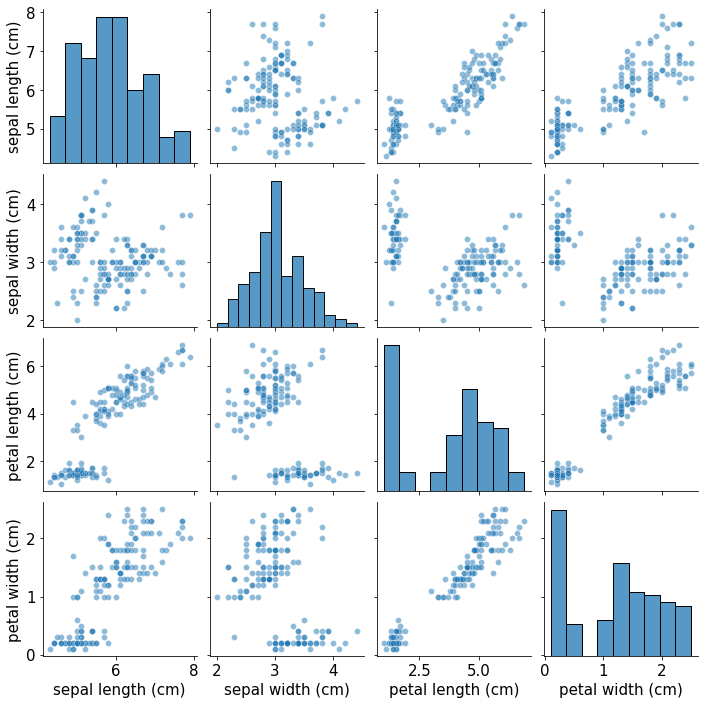

In [67]:
# sample data
X = pd.DataFrame(data['data'], columns=data['feature_names'])
print(X.shape)

sns.pairplot(X, plot_kws={'alpha':0.5})
plt.show()

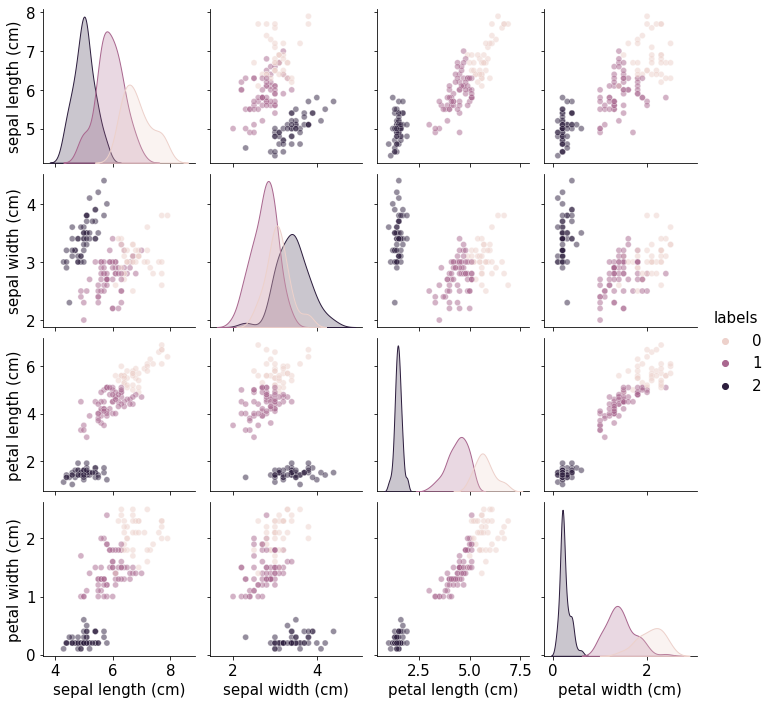

In [68]:
# run our kmeans
X['labels'] = kmeans(X.values, k=3)

# visualize
sns.pairplot(X, hue = 'labels', plot_kws={'alpha':0.5})
plt.show()

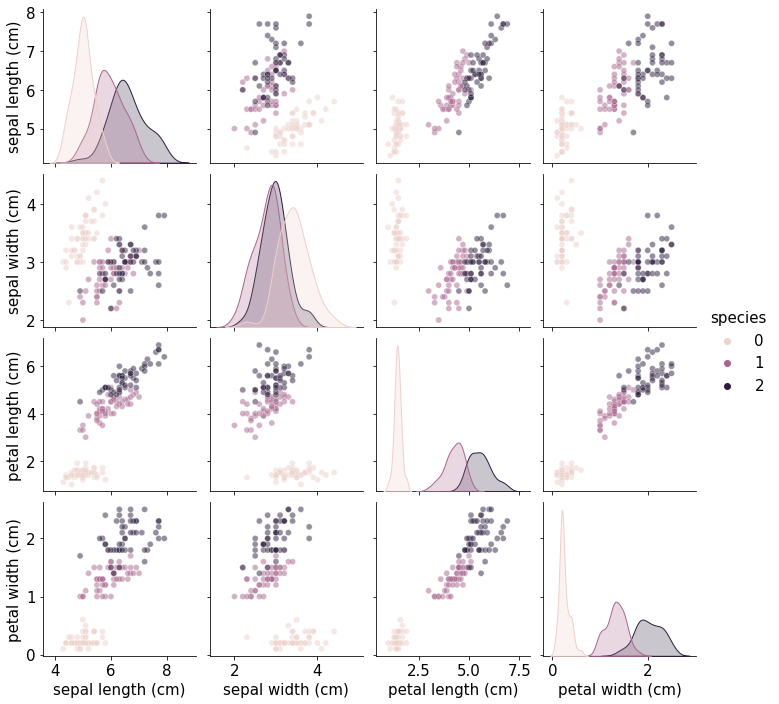

In [70]:
# check with species information
X['species'] = data['target']

sns.pairplot(X.drop(columns='labels'), hue='species', plot_kws={'alpha':0.5})
plt.show()

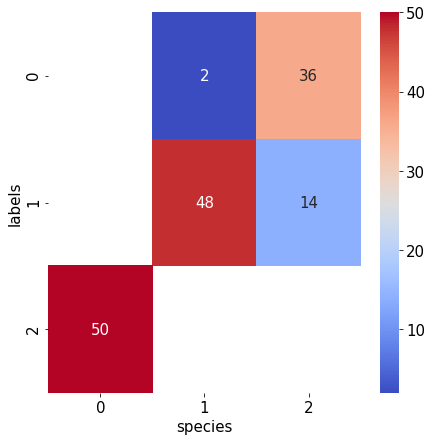

In [79]:
# How good where we? 
df = X.groupby(['species','labels']) \
      .size() \
      .reset_index(name='count') \
      .pivot(index = 'labels', columns = 'species', values = 'count')

g = sns.heatmap(df, cmap='coolwarm', annot=True)
plt.show()

Although in real unsupervised learning problems we don't have ground truth labels (or we don't know which ones they are), in this case we can see that k-means is able to assign the different plants observed to their species quite well using information from their sepal and petals.

## Hierarchical clustering

## Gaussian Mixture Models

## Finding the "key"